In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from sklearn import linear_model
from scipy import stats 
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from itertools import combinations 
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':16});
# plt.style.use('dark_background')
# dt_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] # dark theme colors
figdir = '/Users/aqib/Desktop/BCCL/adp1-adaptation/slides/'
import seaborn as sns
import pickle
from Bio import SeqIO # biopython package
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from bioservices import UniProt 
import os

#### load kallisto results

In [25]:
# get all sample directories
dirs = next(os.walk('.'))[1]
# remove any unwanted directories
for ii,this_dir in enumerate(dirs): 
    if this_dir[0] == '.':
        del dirs[ii]

# the order in which we want the samples in 
dirs = ['LB0R1_S7','LB0R2_S8','LB0R3_S9','LB1R1_S10','LB1R2_S11','LB1R3_S12',
       'M9L8R1_S4','M9L8R2_S5','M9L8R3_S6','M95fR1_S1','M95fR2_S2','M95fR3_S3']
nsamples = len(dirs)

# Generating a dictionary with dataframe for each sample
df_dict = {} # raw counts are available here
for this_dir in dirs:
    df_dict[this_dir] = pd.read_csv(this_dir+'/abundance.tsv',sep='\t')
target_ids = list(df_dict[this_dir].target_id)

# generate df where the first column is target_id and the next columns are TPM from each sample
temp_dict = {'target_id':target_ids}
temp_dict_cts = {'target_id':target_ids}
for sample,this_df in zip(list(df_dict.keys()),df_dict.values()): 
    temp_dict[sample] = this_df.tpm
    temp_dict_cts[sample] = this_df.est_counts
df = pd.DataFrame(temp_dict)
df.columns = ['target_id', 'LB0R1','LB0R2','LB0R3','LB1R1','LB1R2','LB1R3','M9LQR1','M9LQR2','M9LQR3',
             'M9SFR1','M9SFR2','M9SFR3']
df_cts = pd.DataFrame(temp_dict_cts)
df_cts.columns = ['target_id', 'LB0R1','LB0R2','LB0R3','LB1R1','LB1R2','LB1R3','M9LQR1','M9LQR2','M9LQR3',
             'M9SFR1','M9SFR2','M9SFR3']
df

,target_id,LB0R1,LB0R2,LB0R3,LB1R1,LB1R2,LB1R3,M9LQR1,M9LQR2,M9LQR3,M9SFR1,M9SFR2,M9SFR3
0,lcl|NC_005966.1_cds_WP_004930068.1_1,254.4710,195.2650,258.4730,275.9580,240.0250,217.3340,56.17540,55.1445,45.2804,147.6370,127.7610,157.6420
1,lcl|NC_005966.1_cds_WP_004930066.1_2,257.9470,222.5650,246.4550,334.2180,211.9420,223.8630,27.43750,51.0805,53.3345,181.7740,142.9680,218.1870
2,lcl|NC_005966.1_cds_WP_004930061.1_3,217.0360,206.5120,152.5050,141.9870,180.9460,144.0180,81.63770,64.7067,70.0990,48.5840,52.2221,57.3814
3,lcl|NC_005966.1_cds_WP_004930060.1_4,496.6680,476.1380,357.3170,399.3490,494.2160,271.7890,84.41360,91.6070,105.7230,143.1010,141.5100,151.8540
4,lcl|NC_005966.1_cds_WP_004930057.1_5,47.7092,56.7863,48.9246,133.3450,55.1851,44.6848,1739.33000,2147.7500,1420.1400,292.3550,458.4010,280.9240
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3248,lcl|NC_005966.1_cds_WP_004930080.1_3249,84.0684,83.1013,71.1711,82.9277,76.4360,65.6913,13.62630,13.7398,13.7850,36.7306,36.9118,38.8212
3249,lcl|NC_005966.1_cds_WP_004930076.1_3250,424.3720,490.5040,355.0440,439.3470,417.1820,345.5560,34.16200,34.1776,39.3620,126.3570,64.6350,137.3820
3250,lcl|NC_005966.1_cds_WP_004930074.1_3251,630.3330,511.0390,538.2720,654.0400,683.3840,488.8550,6.47030,15.0932,20.0422,106.1690,90.2611,176.4470
3251,lcl|NC_005966.1_cds_WP_011182867.1_3252,364.1350,379.0110,528.9510,618.7390,363.8400,402.5070,4.51108,10.5030,27.7687,257.1650,213.7850,405.4190


In [26]:
fasta_path = 'GCF_000046845.1_ASM4684v1_cds_from_genomic.fna'
genbank_path = 'GCF_000046845.1_ASM4684v1_genomic.gbff'
# fasta_records = list(SeqIO.parse(fasta_path,'fasta')) # full cds_from_genome fasta

In [31]:
def getRecords(fasta_path,genbank_path,target_ids):
    # have to use cds_from_genome.fasta because this is the where the target_ids came from (e.g. lcl|AM181176.4_cds_CAY53368.1_5775)
    fasta_records = list(SeqIO.parse(fasta_path,'fasta')) # full cds_from_genome fasta
    keep_fasta_records = [] # getting records of genes that we have used
    for tx in target_ids:
        for rec in fasta_records:
            if rec.name == tx:
                keep_fasta_records.append(rec)
    # match locus_tags in keep_records (from fasta) with tags in genbank to easily parse rest of cds' description 
    # can grab locus_tags from the fasta description, other info need to grab from the genbank
    genes, locus_tags = [],[] 
    for rec in keep_fasta_records:
        rec_elems = [x.strip().strip(']') for x in rec.description.split(' [')]
        if 'gene=' in str(rec_elems): # sequence has gene name (e.g. gene=dnaA)
            genes.append(rec_elems[1][5:])
            locus_tags.append(rec_elems[2][10:])
        elif 'gene=' not in str(rec_elems): # sequence has no gene name, but has locus tag
            genes.append('N/A')
            locus_tags.append(rec_elems[1][10:])
    gb_records = next(SeqIO.parse(genbank_path,'genbank'))
    
    locations = []
    for tag in locus_tags:
            for feature in gb_records.features:
                if feature.type == 'CDS':
                    if feature.qualifiers['locus_tag'][0] == tag: 
                        if feature.strand == 1: # 5' -> 3'
                            locations.append([feature.location.start.position,feature.location.end.position,1])
                        elif feature.strand == -1: # 3' -> 5' (complementary)
                            locations.append([feature.location.start.position,feature.location.end.position,-1])            
    
    return genes, locus_tags, locations

In [34]:
# get gene names, locus_tags and also locations for when that might be needed
all_genes,all_tags,locs = getRecords(fasta_path,genbank_path,target_ids)


In [37]:
def plotCounts(cts,cts_mean,this_tag='',this_gene=0,title='n/a'):
    fig,ax = plt.subplots(figsize=(4,3))
    ax.set_title(title + ', '+ this_tag)
#     ax.set_text(cts.index[this_gene])
    for ii in range(cts.shape[1]):
        this_col = cts.columns[ii].split('R')[0]
        ax.plot(this_col,cts.iloc[this_gene,ii],'o',c='k',ms=10,mfc='white',mew=2)
        if (ii+1)%nreps == 0:
            ax.hlines(cts_mean.iloc[this_gene,ii//nreps],ii//nreps-0.25,ii//nreps+0.25,
                      color='red',linewidth=2)
    ax.set_ylabel('normalized count')
#     plt.savefig(figdir+title+'.pdf',dpi=300,transparent=True,bbox_inches='tight')  

def plotManyCounts(cts,cts_mean,tags,subplots_shape=(8,8),figsize=(24,24),savefig=False):
    nRows = subplots_shape[0]
    nCols = subplots_shape[1]
    fig,axs = plt.subplots(nRows,nCols,figsize=figsize,sharex=True)
    for ii,ax in enumerate(axs.reshape(-1)):
        this_tag = tags[ii]
        this_gene = list(cts.index).index(this_tag)
        gene_name = all_genes[all_tags.index(this_tag)]
        if gene_name == 'N/A':            
            ax.set_title(this_tag)
        else: 
            ax.set_title(gene_name)

        for jj in range(cts.shape[1]):
            this_col = cts.columns[jj].split('R')[0]
            ax.plot(this_col,cts.iloc[this_gene,jj],'o',c='k',ms=10,mfc='white',mew=2)
            if (jj+1)%nreps == 0:
                ax.hlines(cts_mean.iloc[this_gene,jj//nreps],jj//nreps-0.25,jj//nreps+0.25,
                          color='red',linewidth=2)
        if ii%subplots_shape[0] == 0:
            ax.set_ylabel('normalized count')
    plt.tight_layout()
    if savefig: 
        plt.savefig(figdir+'library_genes_RNAseq'+'.pdf',dpi=300,transparent=True,bbox_inches='tight')  
    

### Import DESeq2 normalized counts and results

In [3]:
cts_norm = pd.read_csv('count_matrix_filtered_normalized.csv',index_col=0)
tags = list(cts_norm.index)
# res_LB1_LB0 = pd.read_csv('LB1_vs_LB0_res.csv',index_col=0)
res_M9LQ_LB0 = pd.read_csv('M9LQ_vs_LB0_res.csv',index_col=0)
res_M9SF_LB0 = pd.read_csv('M9SF_vs_LB0_res.csv',index_col=0)
res_M9LQ_LB1 = pd.read_csv('M9LQ_vs_LB1_res.csv',index_col=0)
res_M9SF_LB1 = pd.read_csv('M9SF_vs_LB1_res.csv',index_col=0)
res_M9SF_M9LQ = pd.read_csv('M9SF_vs_M9LQ_res.csv',index_col=0)

In [4]:
# create a dictionary that contains the results
# the second condition name in each key is the reference
res = {'M9LQvsLB0':res_M9LQ_LB0,'M9SFvsLB0':res_M9SF_LB0,
       'M9LQvsLB1':res_M9LQ_LB1,'M9SFvsLB1':res_M9SF_LB1,'M9SFvsM9LQ':res_M9SF_M9LQ}

In [5]:
# get replicate averages and standard deviations
nreps = 3
cts_mean = cts_norm.groupby(np.arange(len(cts_norm.columns)) // nreps, axis=1).mean()
cts_mean.columns = ['LB0','LB1','M9LQ','M9SF']
cts_std = cts_norm.groupby(np.arange(len(cts_norm.columns)) // nreps, axis=1).std()
cts_std.columns = ['LB0','LB1','M9LQ','M9SF']

## Exploring the results

### M (log-ratio) A (average) plot

In [ ]:
fig,axs = plt.subplots(2,3,figsize=(20,10),sharex=True,sharey=True)
plt.rcParams.update({'font.size':22});
for comp,ax in zip(res,axs.reshape(-1)):
    ax.set_title(comp,fontsize=22)
    these_colors = ['lightgray'] * len(res[comp])
    for ii,elem in enumerate(res[comp].padj<0.05):
        if elem == True and res[comp].log2FoldChange[ii] > 0:
            these_colors[ii] = dt_colors[0]
        elif elem == True and res[comp].log2FoldChange[ii] < 0:
            these_colors[ii] = dt_colors[3]
    ax.scatter(res[comp].baseMean,res[comp].log2FoldChange,s=10,c=these_colors,alpha=0.75)
    ax.hlines(0,np.min(res[comp].baseMean)-100,np.max(res[comp].baseMean)+100,color=dt_colors[1],linewidth=4)
# axs[0,0].l
ax.set_xscale('log')
fig.text(0.4,0.05,'mean of normalized counts',fontsize=22) # xlabel
fig.text(0.075,0.4,'log2(fold change)',rotation='vertical',fontsize=22) # ylabel
# plt.savefig(figdir+'MAplots.pdf',dpi=300,transparent=True,bbox_inches='tight')  
# plt.tight_layout()
plt.show()

### Volcano plot

In [ ]:
fig,axs = plt.subplots(2,3,figsize=(14,8),sharex=True,sharey=True)
# plt.rcParams.update({'font.size':16});
for comp,ax in zip(res,axs.reshape(-1)):
    ax.set_title(comp,fontsize=22)
    these_colors = ['white'] * len(res[comp])
    for ii,elem in enumerate(res[comp].padj<0.05):
        if elem == True and (np.abs(res[comp].log2FoldChange)[ii] > 2):
            these_colors[ii] = dt_colors[5]
    ax.scatter(res[comp].log2FoldChange,-np.log10(res[comp].padj),s=40,c=these_colors,edgecolors='k',
              linewidths=0.75)
    ax.hlines(-np.log10(0.05),-8,8,color='lightgray',linewidth=2,linestyles='dashdot')
    ax.vlines(2,0,180,color='lightgray',linewidth=2,linestyles='dashdot')
    ax.vlines(-2,0,180,color='lightgray',linewidth=2,linestyles='dashdot')
    ax.vlines(0,0,180,color='lightgray',linewidth=1,linestyles='dotted')
# axs[0,0].set_xlim(-8,8)
# axs[0,0].set_ylim(-5,180)
# ax.set_xscale('log')
fig.text(0.4,0.03,r'$\log_2(\mathrm{fold-change})$',fontsize=24) # xlabel
fig.text(0.05,0.36,r'$-\log_{10}(\mathrm{FDR})$',rotation='vertical',fontsize=24) # ylabel
# plt.savefig(figdir+'volcanoplots.pdf',dpi=300,transparent=True,bbox_inches='tight')  
# plt.tight_layout()
plt.show()

### Make list of significantly disregulated genes in each comparison (sorted by log2FoldChange)

In [6]:
# get genes with padj less than 0.05 and abs(log2fc > c)
resSig = {}
for key in res: 
    resSig[key] = (res[key].loc[res[key].padj < 0.05]) # .sort_values('log2FoldChange')
    resSig[key] = resSig[key].loc[np.abs(resSig[key].log2FoldChange) > 2.0].sort_values('log2FoldChange')

In [7]:
# # write to csv
# for key in disregulated: 
#     disregulated[key].to_csv('disregulated_'+key+'.csv',index=True)

#### relevant sets of DE genes

In [8]:
# set of all DE genes exclusive of condition (union)
allDE = set()
for key in resSig:
    allDE = allDE.union(resSig[key].index)
    print(len(allDE))

print('\n')
# set of all DE genes across all pairwise comparisons (intersection)
intersectDE = resSig['M9LQvsLB0'].index
for key in resSig: 
    intersectDE = intersectDE.intersection(resSig[key].index)
    print(len(intersectDE))

704
856
933
954
1004


704
255
236
223
30


#### now we want to select a set of 64 genes for the library

In [15]:
library_genes = list(intersectDE) # these for sure
print(len(library_genes))
# now grab the top fold changes from DE_union

# need to first remove the intersectDE genes from resSig
resSig_new = {}
for key in resSig: 
    resSig_new[key] = resSig[key][~resSig[key].index.isin(library_genes)]

nTop = 12
this_df = resSig_new['M9LQvsLB0']
this_df = this_df.reindex(this_df.log2FoldChange.abs().sort_values().index)
M9LQvsLB0_top = this_df.index[-nTop:]

nTop = 12
this_df = resSig_new['M9LQvsLB1']
this_df.reindex(this_df.log2FoldChange.abs().sort_values().index)
M9LQvsLB1_top = this_df.index[-nTop:]

nTop = 12
this_df = resSig_new['M9SFvsLB0']
this_df.reindex(this_df.log2FoldChange.abs().sort_values().index)
M9SFvsLB0_top = this_df.index[-nTop:]

nTop = 12
this_df = resSig_new['M9SFvsLB1']
this_df.reindex(this_df.log2FoldChange.abs().sort_values().index)
M9SFvsLB1_top = this_df.index[-nTop:]

class_balance_DE_genes = set(M9LQvsLB0_top).union(set(M9LQvsLB1_top),set(M9SFvsLB0_top),set(M9SFvsLB1_top))
len(class_balance_DE_genes)

library_genes = library_genes + list(class_balance_DE_genes)
print(len(library_genes))

30
64


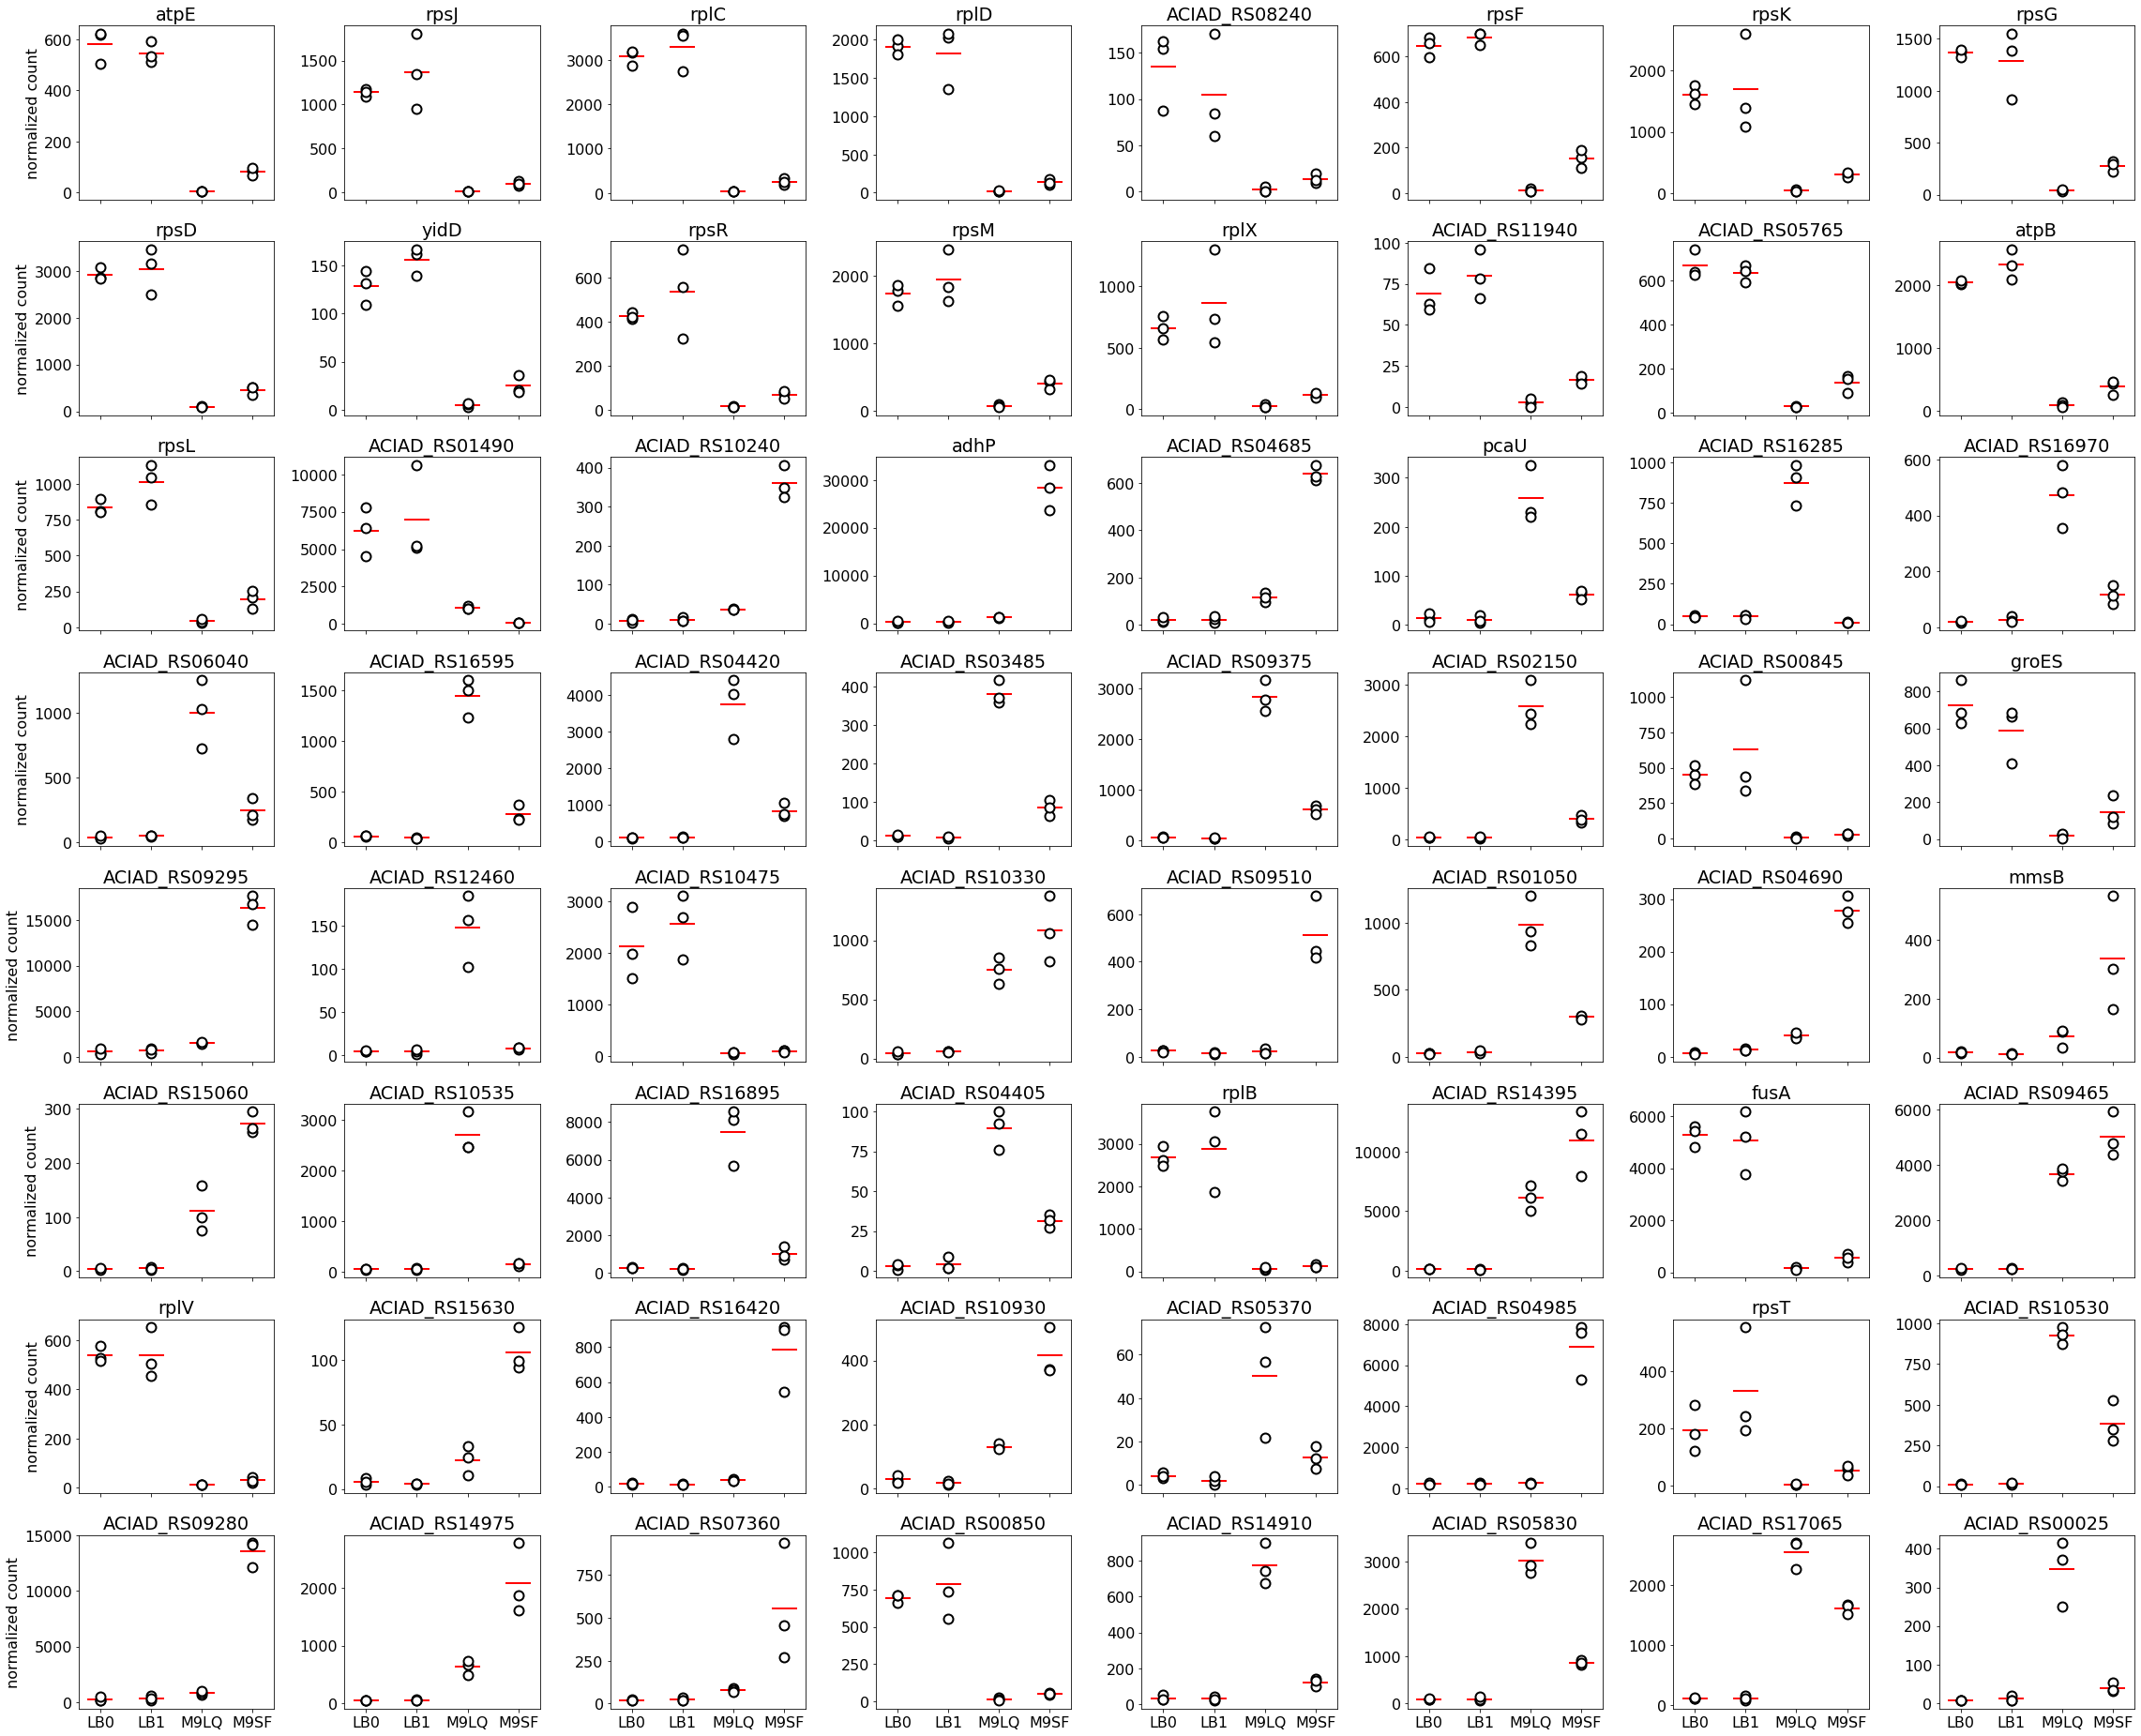

In [38]:
plotManyCounts(cts_norm,cts_mean,library_genes,figsize=(32,26),savefig=False)

#### correlation between library genes to avoid redundancy

In [41]:
library_df = cts_norm[cts_norm.index.isin(library_genes)]


(64, 12)

#### send largest fold change for each gene in the union set to Charles

In [64]:
# grab all DE genes only
resSig_union = {}
for key in resSig: 
    resSig_union[key] = resSig[key][resSig[key].index.isin(list(allDE))] 


fc_dict = {key: [] for key in list(allDE)}
for gene in list(allDE):
    for key in resSig_union:
        try:
            this_ind = list(resSig_union[key].index).index(gene)
            fc_dict[gene].append(resSig_union[key].log2FoldChange[this_ind])
        except:
            fc_dict[gene].append(0.0)

# now keep only the maximum element in each column
fc_max_dict = {}
for ii in range(fc_df.shape[1]):
    print(np.abs(fc_df.iloc[:,ii]))
        

0    3.078106
1    0.000000
2    3.134929
3    0.000000
4    0.000000
Name: ACIAD_RS03975, dtype: float64
0    2.750645
1    0.000000
2    2.747275
3    0.000000
4    0.000000
Name: ACIAD_RS00460, dtype: float64
0    0.000000
1    0.000000
2    0.000000
3    0.000000
4    2.295433
Name: ACIAD_RS07430, dtype: float64
0    3.895974
1    2.964859
2    3.846166
3    2.915051
4    0.000000
Name: ACIAD_RS03400, dtype: float64
0    2.638912
1    0.000000
2    2.360272
3    0.000000
4    0.000000
Name: ACIAD_RS05630, dtype: float64
0    0.000000
1    0.000000
2    0.000000
3    0.000000
4    2.959327
Name: ACIAD_RS02305, dtype: float64
0    3.034276
1    3.365558
2    3.547291
3    3.878573
4    0.000000
Name: ACIAD_RS04640, dtype: float64
0    0.000000
1    3.200128
2    0.000000
3    3.396203
4    0.000000
Name: ACIAD_RS07860, dtype: float64
0    0.000000
1    0.000000
2    2.176562
3    0.000000
4    0.000000
Name: ACIAD_RS04735, dtype: float64
0    0.000000
1    0.000000
2    2.079993
3   

Name: ACIAD_RS02845, dtype: float64
0    0.000000
1    4.173048
2    2.452246
3    4.714151
4    2.214492
Name: ACIAD_RS07365, dtype: float64
0    0.000000
1    0.000000
2    0.000000
3    0.000000
4    2.139545
Name: ACIAD_RS10640, dtype: float64
0    2.804758
1    0.000000
2    2.873531
3    0.000000
4    0.000000
Name: ACIAD_RS02555, dtype: float64
0    2.605694
1    0.000000
2    2.147750
3    0.000000
4    0.000000
Name: ACIAD_RS03995, dtype: float64
0    0.000000
1    0.000000
2    0.000000
3    0.000000
4    2.138038
Name: ACIAD_RS06755, dtype: float64
0    2.895959
1    2.794138
2    2.614640
3    2.512819
4    0.000000
Name: ACIAD_RS09570, dtype: float64
0    3.651798
1    0.000000
2    3.626490
3    0.000000
4    3.551788
Name: ACIAD_RS10970, dtype: float64
0    0.000000
1    2.606441
2    0.000000
3    3.135754
4    0.000000
Name: ACIAD_RS10100, dtype: float64
0    2.092301
1    0.000000
2    2.230327
3    0.000000
4    0.000000
Name: ACIAD_RS03320, dtype: float64
0    2.818

Name: ACIAD_RS01770, dtype: float64
0    0.000000
1    2.230845
2    0.000000
3    2.681304
4    0.000000
Name: ACIAD_RS09610, dtype: float64
0    3.258566
1    2.758498
2    3.422922
3    2.922854
4    0.000000
Name: ACIAD_RS16165, dtype: float64
0    2.988362
1    0.000000
2    3.074672
3    0.000000
4    2.816705
Name: ACIAD_RS12815, dtype: float64
0    2.675777
1    0.000000
2    2.733619
3    0.000000
4    0.000000
Name: ACIAD_RS09440, dtype: float64
0    0.00000
1    2.00735
2    0.00000
3    0.00000
4    0.00000
Name: ACIAD_RS05995, dtype: float64
0    2.588470
1    0.000000
2    2.923689
3    0.000000
4    2.288596
Name: ACIAD_RS05560, dtype: float64
0    2.707870
1    2.177754
2    2.583374
3    2.053258
4    0.000000
Name: ACIAD_RS00115, dtype: float64
0    0.000000
1    2.606257
2    0.000000
3    2.921848
4    0.000000
Name: ACIAD_RS07555, dtype: float64
0    0.000000
1    0.000000
2    0.000000
3    0.000000
4    2.208201
Name: ACIAD_RS10905, dtype: float64
0    2.062791
1

In [69]:
# pd.DataFrame(np.max(np.abs(fc_df),axis=0)).to_csv('max_fc_DE_union.csv')


In [ ]:
# pd.DataFrame(list(allDE)).to_csv('DE_union.csv',index=False)
# pd.DataFrame(list(intersectDE)).to_csv('DE_intersection.csv',index=False)

In [ ]:
# DE genes in M9LQ with respect to LB
M9LQvsLB = set(resSig['M9LQvsLB0'].index).union(resSig['M9LQvsLB1'].index)
# DE genes in M9SF with respect to LB
M9SFvsLB = set(resSig['M9SFvsLB0'].index).union(resSig['M9SFvsLB1'].index)
# DE genes in any M9 condition with respect to LB (A union B)
M9vsLB_union = M9LQvsLB.union(M9SFvsLB)
# DE genes in both M9 conditions with respect to LB (A intersect B)
M9vsLB_intersect = M9LQvsLB.intersection(M9SFvsLB)
# DE genes in only M9LQ with respect to LB (M9SF was not DE)
M9LQ_DE_only = (M9LQvsLB - (M9LQvsLB.intersection(M9SFvsLB))).intersection(resSig['M9SFvsM9LQ'].index)
# M9LQ_DE_only = (M9LQvsLB - M9SFvsLB).intersection(resSig['M9SFvsM9LQ'].index)
# DE genes in only M9SF with respect to LB (M9LQ was not DE)
M9SF_DE_only = (M9SFvsLB - M9LQvsLB).intersection(resSig['M9SFvsM9LQ'].index)

In [ ]:
M9vsLB_intersect

In [ ]:
from matplotlib_venn import venn2
venn2([M9LQvsLB,M9SFvsLB],('M9LQ vs LB','M9SF vs LB'))

In [ ]:
cts_norm

In [ ]:
thresh_list = [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,6.5]
num_DEs_for_thresh = []
for thresh in thresh_list:
    # get genes with padj less than 0.05 and abs(log2fc > c)
    resSig = {}
    for key in res: 
        resSig[key] = (res[key].loc[res[key].padj < 0.05]) # .sort_values('log2FoldChange')
        resSig[key] = resSig[key].loc[np.abs(resSig[key].log2FoldChange) > thresh].sort_values('log2FoldChange')

    # set of all DE genes exclusive of condition
    allDE = set()
    for key in resSig:
        allDE = allDE.union(resSig[key].index)
    num_DEs_for_thresh.append(len(allDE))
    print(len(allDE))

In [ ]:
plt.figure()
plt.plot(thresh_list,num_DEs_for_thresh,lw=2)
plt.ylabel('number of DE genes')
plt.xlabel(r'$\log_2(\mathrm{fold-change})$ threshold')
plt.show()